<a href="https://colab.research.google.com/github/duybluemind1988/Data-science/blob/master/Sonion/Sonion_process_control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# All process in multi weeks

## Prepare data

In [16]:
import datetime
import seaborn as sns; sns.set()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from plotly.offline import iplot
import re

import statistics as st
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as scs
from math import sqrt
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [3]:
import glob
path='/content/drive/My Drive/Data/Sonion/Control plan and stast/Control plan 3000/'
#print(path)
all_files1=glob.glob(path + '*.xlsx')
all_files2=glob.glob(path + '*.xlsm')
all_files=all_files1+all_files2
#sort file in directory by reverse:
all_files = sorted(all_files, reverse = False)
print('number of files: ',len(all_files))

number of files:  4


In [4]:
all_files

['/content/drive/My Drive/Data/Sonion/Control plan and stast/Control plan 3000/Control Plan data REC 3000 - WK34 - 2020.xlsm',
 '/content/drive/My Drive/Data/Sonion/Control plan and stast/Control plan 3000/Control Plan data REC 3000 - WK35 - 2020.xlsm',
 '/content/drive/My Drive/Data/Sonion/Control plan and stast/Control plan 3000/Control Plan data REC 3000 - WK36 - 2020.xlsm',
 '/content/drive/My Drive/Data/Sonion/Control plan and stast/Control plan 3000/Control Plan data REC 3000 - WK37 - 2020.xlsm']

In [5]:
%%time
import xlrd
all_process_week={}
for path_name in all_files:
  week_name=path_name[-16:-5]
  xls = xlrd.open_workbook(path_name, on_demand=True)
  sheet_names=xls.sheet_names()
  #print(xls.sheet_names())
  sheet_dict={}
  xls = pd.ExcelFile(path_name)
  for name in sheet_names:
    sheet_dict[name] = pd.read_excel(xls, name)

  # Read all process in one week
  sheet_all={} # most important
  sheet_error=[]
  for name_sheet in sheet_names[1:]: # all sheet
    #print(name_sheet)
    sheet=sheet_dict[name_sheet]

    # find begin and end col
    values_col=sheet.iloc[22,:]
    values_col.reset_index(drop=True,inplace=True)
    begin_col=values_col[values_col=='Kích thước\nDimension'].index
    begin_col=begin_col+1
    end_col=values_col[values_col=='MSNV'].index
    #print(begin_col,end_col)
  
    df_dict={} # add all value, USL, LSL, UCL... in sheet
    try:
      for name in sheet.columns[begin_col[0]:end_col[0]]:
        
          df=pd.DataFrame()
          
          #tolerance_dict[sheet[name][22]]=[sheet[name][24],sheet[name][23]]
          df['Date']=sheet[sheet.columns[9]][25:]
          df['Date']=df['Date'].apply(lambda x: x.strftime("%Y %m %d %H"))
          df['Date']=pd.to_datetime(df['Date'])
          #df['Hour']=df['Date'].dt.hour
          df['Value']=sheet[name][25:]
          df['USL']=sheet[name][23] # max
          df['LSL']=sheet[name][24] # min
          df.dropna(subset=['Value'],inplace=True)
          #UCL,LCL,nominal:
          sigma=3
          df['UCL']=df['Value'].mean() + df['Value'].std()*sigma
          df['LCL']=df['Value'].mean() - df['Value'].std()*sigma
          df['Mean']=df['Value'].mean()
          df[df.columns[1:]]=df[df.columns[1:]].astype('float32')
          dim_name=sheet[name][22]
          df_dict[dim_name]=df.reset_index(drop=True)
    except:
      sheet_error.append(name_sheet)
      continue
    sheet_all[name_sheet]=df_dict
  all_process_week[week_name]=sheet_all
  print(week_name,sheet_error)

WK34 - 2020 ['37560', '30740', '37751']
WK35 - 2020 ['30740', '37750-37940_S2', '37751']
WK36 - 2020 ['37560', '30740', '37751', '37312-38312']
WK37 - 2020 ['37560', '30740', '37751', '37312-38312']
CPU times: user 15 s, sys: 72.7 ms, total: 15.1 s
Wall time: 15.1 s


In [6]:
all_process_week.keys()

dict_keys(['WK34 - 2020', 'WK35 - 2020', 'WK36 - 2020', 'WK37 - 2020'])

In [7]:
base_week=all_process_week[list(all_process_week.keys())[-1]]
base_week.keys() # lấy base là tuần cuối cùng để cập nhật các process mới nhất

dict_keys(['39682', '38682', '30682', '37682', '30665', '30660-37660-38660', '30380-37380-38380', '37670-39670', '37662', '30650-37650 (3500T)', '37650-38655-39650', '37641', '30470-37470', '38546', '39615', '38940', '38594', '37640-38635', '30674-37674-38674 ', '30672-37672-38672', '30592', '30544-37544-38544-39544', '30538', '30530-37530-39530', '30480-37480-38481', '30370-37370-38370 ', '30750-30940-39750 _S1', '30750-30940-39750 _S2', '37750-37940_S1', '37750-37940_S2'])

## Concat all week to one base week

In [8]:
# concat all process in each weeks based on keys value:
%%time
for week_name in list(all_process_week.keys())[:-1]: # ko tính base week nên từ 1: 
  other_week=all_process_week[week_name]
  for process_name in other_week.keys(): # dict all process
    for process_name_base in base_week.keys(): # dict all process
        if process_name_base==process_name:
          for dim_name in base_week[process_name_base].keys(): # dict all dim in each process
             base_week[process_name_base][dim_name]=pd.concat([base_week[process_name_base][dim_name],other_week[process_name_base][dim_name]])
    #print(process_name)


CPU times: user 320 ms, sys: 20 µs, total: 320 ms
Wall time: 319 ms


In [9]:
base_week.keys() # combine all weeks

dict_keys(['39682', '38682', '30682', '37682', '30665', '30660-37660-38660', '30380-37380-38380', '37670-39670', '37662', '30650-37650 (3500T)', '37650-38655-39650', '37641', '30470-37470', '38546', '39615', '38940', '38594', '37640-38635', '30674-37674-38674 ', '30672-37672-38672', '30592', '30544-37544-38544-39544', '30538', '30530-37530-39530', '30480-37480-38481', '30370-37370-38370 ', '30750-30940-39750 _S1', '30750-30940-39750 _S2', '37750-37940_S1', '37750-37940_S2'])

## Line chart

In [10]:
constants={
    2:1.128,
    3:1.693,
    4:2.059,
    5:2.326,
    6:2.534,
    7:2.704,
    8:2.847, 
    9: 2.970,
    10: 3.078,
    11: 3.173,
    12: 3.258,
    13: 3.336,
    14: 3.407,
    15: 3.472,
    16: 3.532,
    17:3.588,
    18:3.640,
    19:3.689,
    20:3.735,
}

In [11]:
def process_performance(df):
  #print('dim: ',name)
  n=df.Date.value_counts()[0]
  num_sample=n*25
  df=df[-num_sample:]
  usl=df.USL[0]
  lsl=df.LSL[0]
  m=df.Mean[0]

  #Ppk
  sigma=st.stdev(df.Value)
  Pp = float(usl - lsl) / (6*sigma)
  Ppu = float(usl - m) / (3*sigma)
  Ppl = float(m - lsl) / (3*sigma)
  Ppk = np.min([Ppu, Ppl])
  print('Pp:{:.2f} , Ppk: {:.2f}'.format(Pp,Ppk))
  #Cpk
  
  temp=df.groupby('Date').agg({'Value':['min','max']})
  temp['R']=temp['Value','max']-temp['Value','min']
  R=temp['R'].mean()

  if n <= 20:
    sigma_within = R/constants[n]
  else:
    sigma_within = R/constants[20]

  Cp = float(usl - lsl) / (6*sigma_within)
  Cpu = float(usl - m) / (3*sigma_within)
  Cpl = float(m - lsl) / (3*sigma_within)
  Cpk = np.min([Cpu, Cpl])
  print('Cp:{:.2f} , Cpk:{:.2f}'.format(Cp,Cpk))
 

In [20]:
for sheet_name in list(base_week.keys())[:1]:
  print(sheet_name)
  df_dict=base_week[sheet_name] # process
  for name in df_dict.keys(): #also group
    df=df_dict[name].copy()
    df=df.sort_values(by=['Date'])
    for a in df.columns[1:]:
      df[a] = df[a].round(decimals=3)
    df=df.reset_index(drop=True)
    try:
      process_performance(df)
    except: 
      print('error calculate process performance')
    # Draw control chart
    df_group=df.groupby('Date').mean()
    #df=df.set_index('Date')
    #if start_date != '':
    #  df=df[start_date:end_date]
    #Control chart 1 
    fig=go.Figure()
    fig.add_trace(go.Scatter(
                            x=df_group.index, y=df_group['Value'],mode='lines+markers',
                            name='mean ' + name,line=dict( color='#4280F5'),text='DNN'
                            ))
    #USL, LSL
    fig.add_trace(go.Scatter(x=df_group.index, y=df_group['USL'],name='USL '+name, line=dict( color='#FF5733'),mode='lines'))
    fig.add_trace(go.Scatter(x=df_group.index, y=df_group['LSL'],name='LSL '+name,line=dict( color='#FF5733'),mode='lines'))
    #fig.append_trace(go.Scatter(x=df['Datef'], y=df['Nominal'],name='Nominal '+name,line=dict( color='#FF5733')),row=i, col=1)
    # UCL, LCL
    fig.add_trace(go.Scatter(x=df_group.index, y=df_group['UCL'],name='UCL '+name, line=dict( color='#33C2FF'),mode='lines'))
    fig.add_trace(go.Scatter(x=df_group.index, y=df_group['LCL'],name='LCL '+name, line=dict( color='#33C2FF'),mode='lines'))
    fig.add_trace(go.Scatter(x=df_group.index, y=df_group['Mean'],name='Mean '+name, line=dict( color='#33C2FF'),mode='lines'))
    fig.update_layout(height=300, width=1200, title_text=name)
    fig.show()

  #fig.update_layout(height=200*len(df_dict), width=1200, title_text=sheet_name)
  #fig update each process (contain a lot of dim inside)
 

39682
Pp:0.60 , Ppk: 0.18
Cp:0.86 , Cpk:0.26


Pp:0.71 , Ppk: 0.28
Cp:0.77 , Cpk:0.31


Pp:0.83 , Ppk: 0.58
Cp:0.84 , Cpk:0.59


Pp:0.92 , Ppk: 0.73
Cp:1.00 , Cpk:0.80


Pp:nan , Ppk: nan
Cp:nan , Cpk:nan


### Try better method

In [89]:
def process_performance2(data):
  df=data
  #print('dim: ',name)
  n=df.Date.value_counts()[0]
  num_sample=n*25
  df=df[-num_sample:]
  df=df.reset_index(drop=True)
  usl=df.USL[0]
  lsl=df.LSL[0]
  m=df.Mean[0]

  #Ppk
  sigma=st.stdev(df.Value)
  Pp = float(usl - lsl) / (6*sigma)
  Ppu = float(usl - m) / (3*sigma)
  Ppl = float(m - lsl) / (3*sigma)
  Ppk = np.min([Ppu, Ppl])
  #print('Pp:{:.2f} , Ppk: {:.2f}'.format(Pp,Ppk))
  #Cpk
  
  temp=df.groupby('Date').agg({'Value':['min','max']})
  temp['R']=temp['Value','max']-temp['Value','min']
  R=temp['R'].mean()

  if n <= 20:
    sigma_within = R/constants[n]
  else:
    sigma_within = R/constants[20]

  Cp = float(usl - lsl) / (6*sigma_within)
  Cpu = float(usl - m) / (3*sigma_within)
  Cpl = float(m - lsl) / (3*sigma_within)
  Cpk = np.min([Cpu, Cpl])
  #print('Cp:{:.2f} , Cpk:{:.2f}'.format(Cp,Cpk))
  Cp=str(round(Cp,2))
  Cpk=str(round(Cpk,2))
  Pp=str(round(Pp,2))
  Ppk=str(round(Ppk,2))
  return (Cp,Cpk,Pp,Ppk)
 

In [90]:
for sheet_name in list(base_week.keys()):
  df_dict=base_week[sheet_name] # process name
  i=1
  #Layout
  fig = make_subplots(          # Dim name
      rows=len(df_dict), cols=1,
      #shared_xaxes=True, # share same axis
      #vertical_spacing=0.05, # adjust spacing between charts
      #column_widths=[0.8, 0.2],
      subplot_titles=(list(df_dict.keys()))
  )
  for name in list(df_dict.keys()): #also group
    df=df_dict[name].copy()
    df=df.sort_values(by=['Date'])
    for a in df.columns[1:]:
      df[a] = df[a].round(decimals=3)
    df=df.reset_index(drop=True)
    try:
      Cp,Cpk,Pp,Ppk=process_performance2(df)
    except: 
      print('error calculate process performance:'+ name)
      Cp='NaN'
      Cpk='NaN'
      Pp='NaN'
      Ppk='NaN'
    #print(Cp,Cpk,Pp,Ppk)
    # Draw control chart
    df_group=df.groupby('Date').mean()
    #df=df.set_index('Date')
    #if start_date != '':
    #  df=df[start_date:end_date]
    #Control chart 1 
    fig.append_trace(go.Scatter(
                            x=df_group.index, y=df_group['Value'],mode='lines+markers',
                            name='mean ' +name+' Cp: '+ Cp + ' Pp: '+Pp +' Cpk: '+ Cpk+' Ppk: '+Ppk , 
                            line=dict( color='#4280F5')
                            ),row=i, col=1)
    #USL, LSL
    fig.append_trace(go.Scatter(x=df_group.index, y=df_group['USL'],name='USL '+name, line=dict( color='#FF5733'),mode='lines'),row=i, col=1)
    fig.append_trace(go.Scatter(x=df_group.index, y=df_group['LSL'],name='LSL '+name,line=dict( color='#FF5733'),mode='lines'),row=i, col=1)
    #fig.append_trace(go.Scatter(x=df['Datef'], y=df['Nominal'],name='Nominal '+name,line=dict( color='#FF5733')),row=i, col=1)
    # UCL, LCL
    fig.append_trace(go.Scatter(x=df_group.index, y=df_group['UCL'],name='UCL '+name, line=dict( color='#33C2FF'),mode='lines'),row=i, col=1)
    fig.append_trace(go.Scatter(x=df_group.index, y=df_group['LCL'],name='LCL '+name, line=dict( color='#33C2FF'),mode='lines'),row=i, col=1)
    fig.append_trace(go.Scatter(x=df_group.index, y=df_group['Mean'],name='Mean '+name, line=dict( color='#33C2FF'),mode='lines'),row=i, col=1)
    i=i+1
  

  fig.update_layout(height=200*len(df_dict), width=1200, title_text='Process: '+sheet_name)
  #fig update each process (contain a lot of dim inside)
  fig.show()
 

error calculate process performance:Spout 12-DL_ Vị trí C
error calculate process performance:Spout JH_ Connection strength
error calculate process performance:Spout JH_ Độ lệch vị trí A


error calculate process performance:Lực của mối hàn
Welding spot strength


error calculate process performance:Spout  1-SN_ Connection strength (3300U)
error calculate process performance:Spout  1-SN_ Connection strength (not for 3300U)
error calculate process performance:Spout  1-SN_ Độ lệch vị trí A
error calculate process performance:Spout  1-SN_ Vị trí B
error calculate process performance:Spout 12-DL(dual)_ Connection strength (3300U)
error calculate process performance:Spout 12-DL(dual)_ Connection strength (not for 3300U)
error calculate process performance:Spout 12-DL(dual)_ Độ lệch vị trí G
error calculate process performance:Spout 12-DL(dual)_ Độ lệch vị trí F
error calculate process performance:Spout SC_ Connection strength
error calculate process performance:Spout SC_ Độ lệch vị trí A
error calculate process performance:Spout SC_ Vị trí B


error calculate process performance:Spout 12-DL (single)_ Connection strength 
error calculate process performance:Spout 12-DL (single_ Độ lệch vị trí A
error calculate process performance:Spout 12-DL (single _ Vị trí B
error calculate process performance:Spout JH _ Connection strength
error calculate process performance:Spout JH _ Độ lệch vị trí A
error calculate process performance:Spout JH _ Vị trí C


error calculate process performance:Spout  EL _ Vị trí C_11s
error calculate process performance:Spout 12-SN reversed_Connection strength
error calculate process performance:Spout 12-SN reversed_Độ lệch vị trí F
error calculate process performance:Spout 12-SN reversed_Vị trí C


error calculate process performance:Spout  1-SN (3700U) _ Connection strength
error calculate process performance:Spout  1-SN (3700U) _ Độ lệch vị trí C
error calculate process performance:Spout  1-SN (3700U) _ Vị trí B
error calculate process performance:Spout PD _ Lực xoay 45-135-225-315 strength
error calculate process performance:Spout PD _ Độ lệch vị trí F
error calculate process performance:Spout PD _ Vị trí C


Original (stabel)

In [ ]:
for sheet_name in list(base_week.keys())[:3]:
  df_dict=base_week[sheet_name] # process

  i=1
  #Layout
  fig = make_subplots(              # all dim in each process
      rows=len(df_dict), cols=1,
      #shared_xaxes=True, # share same axis
      #vertical_spacing=0.05, # adjust spacing between charts
      #column_widths=[0.8, 0.2],
      subplot_titles=(list(df_dict.keys()))
  )
  for name in df_dict.keys(): #also group
    df=df_dict[name].copy()
    df=df.sort_values(by=['Date'])
    for a in df.columns[1:]:
      df[a] = df[a].round(decimals=3)
    df=df.reset_index(drop=True)
    try:
      process_performance(df)
    except: 
      print('error calculate process performance')
    # Draw control chart
    df=df.groupby('Date').mean()
    #df=df.set_index('Date')
    #if start_date != '':
    #  df=df[start_date:end_date]
    #Control chart 1 
    fig.append_trace(go.Scatter(
                            x=df.index, y=df['Value'],mode='lines+markers',
                            name='mean ' + name,line=dict( color='#4280F5')
                            ),row=i, col=1
                  )
    #USL, LSL
    fig.append_trace(go.Scatter(x=df.index, y=df['USL'],name='USL '+name, line=dict( color='#FF5733'),mode='lines'),row=i, col=1)
    fig.append_trace(go.Scatter(x=df.index, y=df['LSL'],name='LSL '+name,line=dict( color='#FF5733'),mode='lines'),row=i, col=1)
    #fig.append_trace(go.Scatter(x=df['Datef'], y=df['Nominal'],name='Nominal '+name,line=dict( color='#FF5733')),row=i, col=1)
    # UCL, LCL
    fig.append_trace(go.Scatter(x=df.index, y=df['UCL'],name='UCL '+name, line=dict( color='#33C2FF'),mode='lines'),row=i, col=1)
    fig.append_trace(go.Scatter(x=df.index, y=df['LCL'],name='LCL '+name, line=dict( color='#33C2FF'),mode='lines'),row=i, col=1)
    fig.append_trace(go.Scatter(x=df.index, y=df['Mean'],name='Mean '+name, line=dict( color='#33C2FF'),mode='lines'),row=i, col=1)
    i=i+1

  fig.update_layout(height=200*len(df_dict), width=1200, title_text='process '+sheet_name)
  fig.show()

error calculate process performance
error calculate process performance
error calculate process performance
error calculate process performance
error calculate process performance


error calculate process performance
error calculate process performance
error calculate process performance
error calculate process performance
error calculate process performance
error calculate process performance


error calculate process performance
error calculate process performance
error calculate process performance
error calculate process performance
error calculate process performance
error calculate process performance


error calculate process performance
error calculate process performance


error calculate process performance
error calculate process performance
error calculate process performance
error calculate process performance
error calculate process performance
error calculate process performance
error calculate process performance
error calculate process performance


In [ ]:
import warnings
warnings.filterwarnings("ignore")

Py Manufacturing

In [ ]:
for sheet_name in base_week.keys():
  print('process: ',sheet_name)
  df_dict=base_week[sheet_name]
  for name in df_dict.keys(): #also group
    print('dim: ',name)
    df=df_dict[name].copy()
    df=df.sort_values(by=['Date'])
    for a in df.columns[1:]:
      df[a] = df[a].round(decimals=3)
    try:
      #mn.control_plot(df.Value, upper_control_limit=df.USL[0], lower_control_limit=df.LSL[0])
      mn.ppk_plot(df.Value, upper_control_limit=df.USL[0], lower_control_limit=df.LSL[0])
      mn.cpk_plot(df.Value, upper_control_limit=df.USL[0], lower_control_limit=df.LSL[0],
              subgroup_size=df.Date.value_counts()[0])
    except:
      continue
   

## Box plot chart

In [ ]:
for sheet_name in base_week.keys():
  df_dict=base_week[sheet_name]
    
  i=1
  #Layout
  fig = make_subplots(
      rows=len(df_dict), cols=1,
      #shared_xaxes=True, # share same axis
      vertical_spacing=0.05, # adjust spacing between charts
      #column_widths=[0.8, 0.2],
      subplot_titles=(list(df_dict.keys()))
  )
  for name in df_dict.keys(): #also group
    df=df_dict[name].copy()
    df=df.sort_values(by=['Date'])
    for a in df.columns[1:]:
      df[a] = df[a].round(decimals=3)
    df=df.set_index('Date')
    #Control chart 1 
    fig.append_trace(go.Box(
                            x=df.index, y=df['Value'],
                            name='mean ' + name, line=dict( color='#4280F5')
                            ),row=i, col=1
                  )
    #USL, LSL
    fig.append_trace(go.Scatter(x=df.index, y=df['USL'],name='USL '+name, line=dict( color='#FF5733')),row=i, col=1)
    fig.append_trace(go.Scatter(x=df.index, y=df['LSL'],name='LSL '+name,line=dict( color='#FF5733')),row=i, col=1)
    #fig.append_trace(go.Scatter(x=df['Datef'], y=df['Nominal'],name='Nominal '+name,line=dict( color='#FF5733')),row=i, col=1)
    # UCL, LCL
    i=i+1
    
  fig.update_layout(height=200*len(df_dict), width=1200, title_text=sheet_name)
  #fig.show()

## Calculate Cp/CpK/Ppk from base week (last week)

In [ ]:
constants={
    2:1.128,
    3:1.693,
    4:2.059,
    5:2.326,
    6:2.534,
    7:2.704,
    8:2.847, 
    9: 2.970,
    10: 3.078,
    11: 3.173,
    12: 3.258,
    13: 3.336,
    14: 3.407,
    15: 3.472,
    16: 3.532,
    17:3.588,
    18:3.640,
    19:3.689,
    20:3.735,
}

In [ ]:
import statistics as st
process_indicator={}
for process_name in base_week.keys():
  try:
    #print(process_name)
    process_dict=base_week[process_name]
    for dim in process_dict.keys():
      #print(dim)
      df=process_dict[dim]
      usl=df.USL[0]
      lsl=df.LSL[0]
      m=df.Mean[0]

      #Ppk
      sigma=st.stdev(df.Value)
      Pp = float(usl - lsl) / (6*sigma)
      Ppu = float(usl - m) / (3*sigma)
      Ppl = float(m - lsl) / (3*sigma)
      Ppk = np.min([Ppu, Ppl])
      #print('Pp',Pp)
      #print('Ppk',Ppk)

      #Cpk
      n=df.Date.value_counts()[0]
      temp=df.groupby('Date').agg({'Value':['min','max']})
      temp['R']=temp['Value','max']-temp['Value','min']
      R=temp['R'].mean()

      if n <= 20:
        sigma_within = R/constants[n]
      else:
        sigma_within = R/constants[20]
      
      Cp = float(usl - lsl) / (6*sigma_within)
      Cpu = float(usl - m) / (3*sigma_within)
      Cpl = float(m - lsl) / (3*sigma_within)
      Cpk = np.min([Cpu, Cpl])
      #print('Cp',Cp)
      #print('Cpk',Cpk)
  except:
    print('error:')
    print('process_name: ',process_name)
    print('dim: ',dim)
    continue

error:
process_name:  37670-39670
dim:  3500T Đường kính lỗ bù (dim B)
error:
process_name:  30470-37470
dim:  30470 Chiều dài drive pin sau khi cắt_Dim B 
error:
process_name:  38940
dim:  Spout 12-DL_ Vị trí C
error:
process_name:  30538
dim:  Lực của mối hàn
Welding spot strength
error:
process_name:  30750-30940-39750 _S1
dim:  Spout  1-SN_ Connection strength (3300U)
error:
process_name:  30750-30940-39750 _S2
dim:  Spout 12-DL (single)_ Connection strength 
error:
process_name:  37750-37940_S1
dim:  Spout  EL _ Vị trí C_11s
error:
process_name:  37750-37940_S2
dim:  Spout  1-SN (3700U) _ Connection strength


In [ ]:
import statistics as st
process_name='38682'
process_dict=base_week[process_name]
process_indicator={}
for dim in process_dict.keys():
  print(dim)
  df=process_dict[dim]
  # PPk"
  sigma=st.stdev(df.Value)
  usl=df.USL[0]
  lsl=df.LSL[0]
  m=df.Mean[0]
  Pp = float(usl - lsl) / (6*sigma)
  Ppu = float(usl - m) / (3*sigma)
  Ppl = float(m - lsl) / (3*sigma)
  Ppk = np.min([Ppu, Ppl])
  print('Pp',Pp)
  print('Ppk',Ppk)
  # CPK"
 

Hinge Dim F
Pp 0.8979230733571717
Ppk 0.7243247128588255
Chiều dài Dim B
Pp 0.611506076738254
Ppk 0.36690656193393173
Chiều rộng Dim A
Pp 0.5632059313075698
Ppk 0.5181419371853514
L.Tâm Dim N
Pp 1.4544298377882001
Ppk 0.8959287618724691
Offset Dim M
Pp nan
Ppk nan
Ba vớ trên membrane
Pp nan
Ppk nan


In [ ]:
 process_dict.keys()

dict_keys(['Hinge Dim F', 'Chiều dài Dim B', 'Chiều rộng Dim A', 'L.Tâm Dim N', 'Offset Dim M', 'Ba vớ trên membrane'])

In [ ]:
df=process_dict['Hinge Dim F']
df

,Date,Value,USL,LSL,UCL,LCL,Mean
0,2020-09-04 16:00:00,0.231,0.25,0.21,0.25614,0.211593,0.233867
1,2020-09-04 16:00:00,0.231,0.25,0.21,0.25614,0.211593,0.233867
2,2020-09-04 16:00:00,0.228,0.25,0.21,0.25614,0.211593,0.233867
3,2020-09-05 08:00:00,0.241,0.25,0.21,0.25614,0.211593,0.233867
4,2020-09-05 08:00:00,0.237,0.25,0.21,0.25614,0.211593,0.233867
5,2020-09-05 08:00:00,0.246,0.25,0.21,0.25614,0.211593,0.233867
6,2020-09-07 09:00:00,0.239,0.25,0.21,0.25614,0.211593,0.233867
7,2020-09-07 09:00:00,0.217,0.25,0.21,0.25614,0.211593,0.233867
8,2020-09-07 09:00:00,0.242,0.25,0.21,0.25614,0.211593,0.233867
9,2020-09-08 10:00:00,0.232,0.25,0.21,0.25614,0.211593,0.233867


3

In [ ]:
usl=df.USL[0]
lsl=df.LSL[0]
m=df.Mean[0]

In [ ]:
temp=df.groupby('Date').agg({'Value':['min','max']})
temp

Value       
                       min    max
Date                             
2020-09-04 16:00:00  0.228  0.231
2020-09-05 08:00:00  0.237  0.246
2020-09-07 09:00:00  0.217  0.242
2020-09-08 10:00:00  0.230  0.240
2020-09-08 16:00:00  0.225  0.235

In [ ]:
temp.columns

MultiIndex([('Value', 'min'),
            ('Value', 'max')],
           )

In [ ]:
temp['Value','min']

Date
2020-09-04 16:00:00    0.228
2020-09-05 08:00:00    0.237
2020-09-07 09:00:00    0.217
2020-09-08 10:00:00    0.230
2020-09-08 16:00:00    0.225
Name: (Value, min), dtype: float32

In [ ]:
temp['R']=temp['Value','max']-temp['Value','min']

In [ ]:
temp

Value             R
                       min    max       
Date                                    
2020-09-04 16:00:00  0.228  0.231  0.003
2020-09-05 08:00:00  0.237  0.246  0.009
2020-09-07 09:00:00  0.217  0.242  0.025
2020-09-08 10:00:00  0.230  0.240  0.010
2020-09-08 16:00:00  0.225  0.235  0.010

In [ ]:
R=temp['R'].mean()
R

0.011400002054870129

In [ ]:
constants={
    2:1.128,
    3:1.693,
    4:2.059,
    5:2.326,
    6:2.534,
    7:2.704,
    8:2.847, 
    9: 2.970,
    10: 3.078,
    11: 3.173,
    12: 3.258,
    13: 3.336,
    14: 3.407,
    15: 3.472
}

In [ ]:
n=df.Date.value_counts()[0]
sigma_within=R/constants[n]
sigma_within

0.006733610191890211

In [ ]:
usl=df.USL[0]
lsl=df.LSL[0]
m=df.Mean[0]
Cp = float(usl - lsl) / (6*sigma_within)
Cpu = float(usl - m) / (3*sigma_within)
Cpl = float(m - lsl) / (3*sigma_within)
Cpk = np.min([Cpu, Cpl])
print('Cp',Cp)
print('Cpk',Cpk)

sigma=st.stdev(df.Value)
Pp = float(usl - lsl) / (6*sigma)
Ppu = float(usl - m) / (3*sigma)
Ppl = float(m - lsl) / (3*sigma)
Ppk = np.min([Ppu, Ppl])
print('Pp',Pp)
print('Ppk',Ppk)

Cp 0.9900584633556088
Cpk 0.7986472710878285
Pp 0.8979230733571717
Ppk 0.7243247128588255


In [ ]:
#!pip install manufacturing

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=15



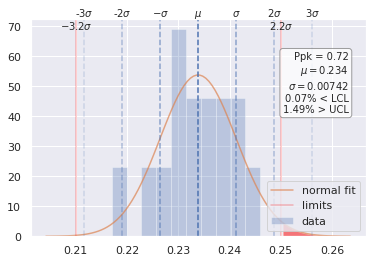

In [ ]:
import manufacturing as mn
mn.ppk_plot(df.Value, upper_control_limit=df.USL[0], lower_control_limit=df.LSL[0])

shapiro test indicates that the distribution is NOT normal
skewtest is not valid with less than 8 samples; 3 samples were given.
the data set is most likely not normally distributed
skewtest is not valid with less than 8 samples; 3 samples were given.
the zupper and zlower limits are strongly imbalanced, indicating that the process is off-center with reference to the limits
skewtest is not valid with less than 8 samples; 3 samples were given.
skewtest is not valid with less than 8 samples; 3 samples were given.
the zupper and zlower limits are strongly imbalanced, indicating that the process is off-center with reference to the limits
skewtest is not valid with less than 8 samples; 3 samples were given.
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=15



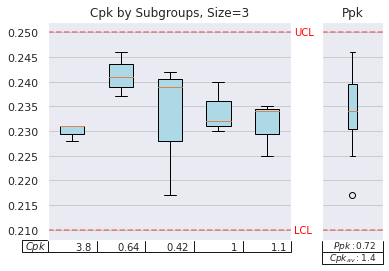

In [ ]:
mn.cpk_plot(df.Value, upper_control_limit=df.USL[0], lower_control_limit=df.LSL[0],
            subgroup_size=3)

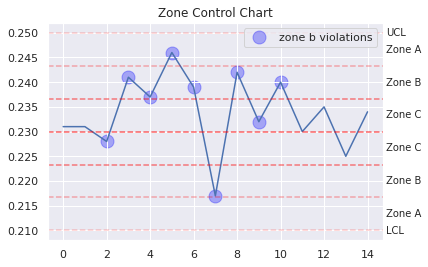

In [ ]:
mn.control_plot(df.Value, upper_control_limit=df.USL[0], lower_control_limit=df.LSL[0])
# Khong group df ở đây